In [1]:
import FinanceDataReader as fdr #주식데이터 불러오기
import OpenDartReader # 주식데이터 openapi 사용툴
import pandas as pd # 데이터저장
import matplotlib as mpl # 시각화
import matplotlib.pyplot as plt # 시각화
import matplotlib.font_manager as fm # 한글폰트 적용
import seaborn as sns # 시각화
import numpy as np
font_path = r'C:\Windows\Fonts\NanumBarunGothic.ttf' # 한글폰트 경로

In [2]:
import warnings
warnings.filterwarnings('ignore')
#오류 제거

In [44]:
df = fdr.DataReader(symbol='005930',start='2019')  
# symbol : 종목코드 , 무조건 6자리 사용
# 시작점 미설정시 : 상장일부터
# 종료점 미설정시 : 현재일까지
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,0.001292
2019-01-03,38300,38550,37450,37600,12471493,-0.029677
2019-01-04,37450,37600,36850,37450,14108958,-0.003989
2019-01-07,38000,38900,37800,38750,12748997,0.034713
2019-01-08,38000,39200,37950,38100,12756554,-0.016774
...,...,...,...,...,...,...
2021-11-04,71200,71600,70500,70600,11818987,0.002841
2021-11-05,71600,71600,70200,70200,12667743,-0.005666
2021-11-08,70400,70600,69800,70600,11121981,0.005698


In [45]:
df = df.rename(columns={'Open' : '시가',   # 이해하기 쉽게 칼럼을 한글로 변경
                        'High' : '고가',
                        'Low' : '저가',
                        'Close' : '종가',
                        'Volume' : '거래량',
                        'Change' : '등락률',                     
                           })
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 706 entries, 2019-01-02 to 2021-11-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가      706 non-null    int64  
 1   고가      706 non-null    int64  
 2   저가      706 non-null    int64  
 3   종가      706 non-null    int64  
 4   거래량     706 non-null    int64  
 5   등락률     706 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 38.6 KB


In [46]:
# 데이터 정규화 0~1로
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled
#df = df.rename_axis('index').reset_index() # 데이터 인덱스 추가

,시가,고가,저가,종가,거래량
0,0.036897,0.030405,0.032289,0.024276,0.040060
1,0.016083,0.016047,0.011396,0.002801,0.093888
2,0.000000,0.000000,0.000000,0.000000,0.112951
3,0.010407,0.021959,0.018044,0.024276,0.097119
4,0.010407,0.027027,0.020893,0.012138,0.097207
...,...,...,...,...,...
701,0.638600,0.574324,0.639126,0.619048,0.086292
702,0.646168,0.574324,0.633428,0.611578,0.096173
703,0.623463,0.557432,0.625831,0.619048,0.078178
704,0.621570,0.564189,0.631529,0.617180,0.078616


In [47]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [72]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [73]:
from sklearn.model_selection import train_test_split

feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.1)
x_train.shape, x_valid.shape
y_train.shape

(437, 1)

In [65]:
test_feature = test[feature_cols]
test_label = test[label_cols]


test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

In [66]:
# Training

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [67]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
18/28 [==================>...........] - ETA: 0s - loss: 0.1161 
Epoch 00001: val_loss improved from inf to 0.03505, saving model to model\tmp_checkpoint.h5
28/28 [==============================] - 1s 8ms/step - loss: 0.0947 - val_loss: 0.0350
Epoch 2/200
19/28 [===================>..........] - ETA: 0s - loss: 0.0102
Epoch 00002: val_loss improved from 0.03505 to 0.00655, saving model to model\tmp_checkpoint.h5
28/28 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 3/200
19/28 [===================>..........] - ETA: 0s - loss: 0.0036
Epoch 00003: val_loss improved from 0.00655 to 0.00386, saving model to model\tmp_checkpoint.h5
28/28 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 4/200
19/28 [===================>..........] - ETA: 0s - loss: 0.0030
Epoch 00004: val_loss improved from 0.00386 to 0.00353, saving model to model\tmp_checkpoint.h5
28/28 [==============================] - 0s 4ms/step -

In [68]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

(180, 1)

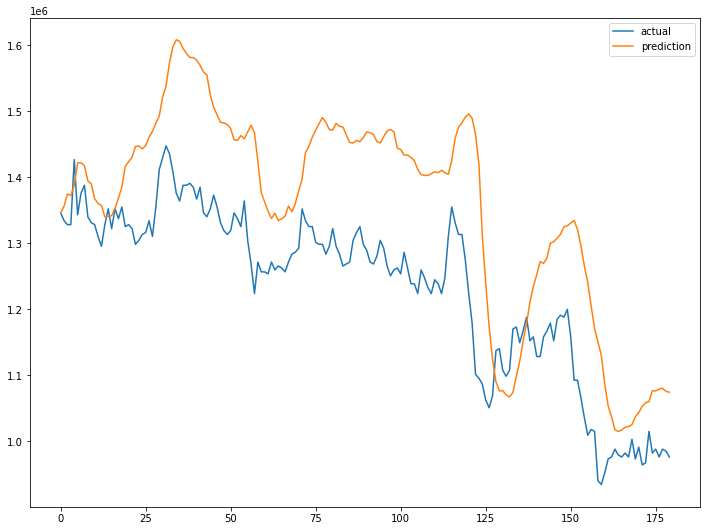

In [69]:
plt.figure(figsize=(12, 9))
plt.plot(test_label*1596226.725984511, label = 'actual')
plt.plot(pred*1596226.725984511, label = 'prediction')
plt.legend()
plt.show()

In [71]:
recent_price = pred[179] * 1596226.725984511
recent_price

array([1074282.], dtype=float32)

In [27]:

cm = confusion_matrix(y_train, pred)

ValueError: Found input variables with inconsistent numbers of samples: [30, 380]

In [ ]:

get_clf_eval(y,pred)

In [ ]:
y.shape